In [2]:
import sys
assert sys.version_info >= (3,5)
import sklearn
assert sklearn.__version__ >= "0.20"

import os
import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [8]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [ ]:
X

## PCA using SVD decomposition

In [9]:
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
c1, c2

(array([0.93636116, 0.29854881, 0.18465208]),
 array([-0.34027485,  0.90119108,  0.2684542 ]))

In [10]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [11]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [12]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [13]:
X2D_using_svd = X2D

## PCA using Scikit-Learn

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [15]:
X3D_inv = pca.inverse_transform(X2D)

In [16]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [17]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [18]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [19]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Saving figure dataset_3d_plot


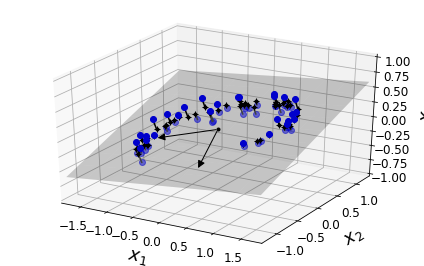

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

Saving figure dataset_2d_plot


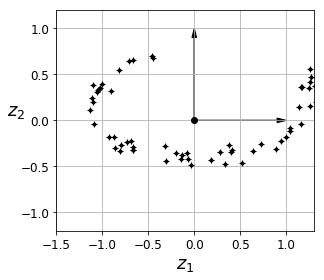

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

# Manifold learning
Swiss roll:

In [22]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


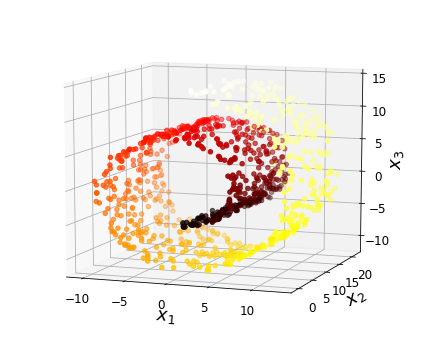

In [23]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

# MNIST compression

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [7]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [27]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

In [28]:
d

154

In [29]:
X.shape

(70000, 784)

In [30]:
d/X.shape[1]

0.19642857142857142

In [31]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X)

X_recovered = pca.inverse_transform(X_reduced)

In [32]:
rand_pca = PCA(n_components=154, svd_solver = "randomized")
X_reduced = rand_pca.fit_transform(X_train)

cumsum = np.sum(rand_pca.explained_variance_ratio_)
cumsum

0.9500323072378446

In [33]:
full_pca = PCA(n_components=154, svd_solver = "full")
X_reduced = full_pca.fit_transform(X_train)

cumsum = np.sum(full_pca.explained_variance_ratio_)
cumsum

0.9503684424557436

In [34]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)

cumsum = np.sum(pca.explained_variance_ratio_)
cumsum

0.9500131834782123

In [35]:
from sklearn.decomposition import IncrementalPCA

In [36]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

# Kernel PCA

In [8]:
from sklearn.decomposition import KernelPCA

In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

### *Question 9*

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X_train = mnist["data"][:60000]
y_train = mnist["target"][:60000]

X_test = mnist["data"][60000:]
y_test = mnist["target"][60000:]

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time

pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

rand_clf = RandomForestClassifier(n_estimators = 200, random_state = 42)

In [14]:
start_time = time.time()
rand_clf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 79.5673201084137 seconds ---


In [15]:
y_pred = rand_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9707


In [18]:
rand_clf = RandomForestClassifier(n_estimators = 200, random_state = 42)
start_time = time.time()
rand_clf.fit(X_train_reduced, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 200.83230423927307 seconds ---


In [20]:
y_pred = rand_clf.predict(X_test_reduced)
print(accuracy_score(y_test, y_pred))

### *Question 10*

In [21]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist["data"][idx]
y = mnist["target"][idx]

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_reduced = tsne.fit_transform(X)

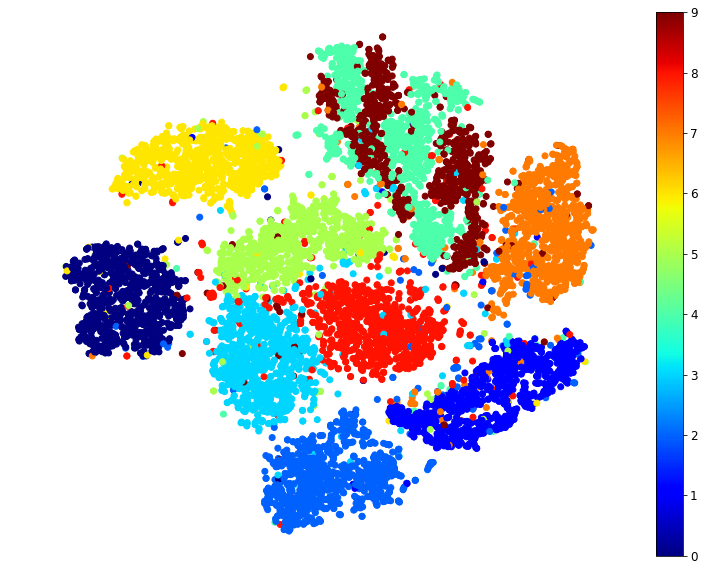

In [32]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize = (13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y, cmap = "jet")
plt.axis("off")
plt.colorbar()
plt.show()

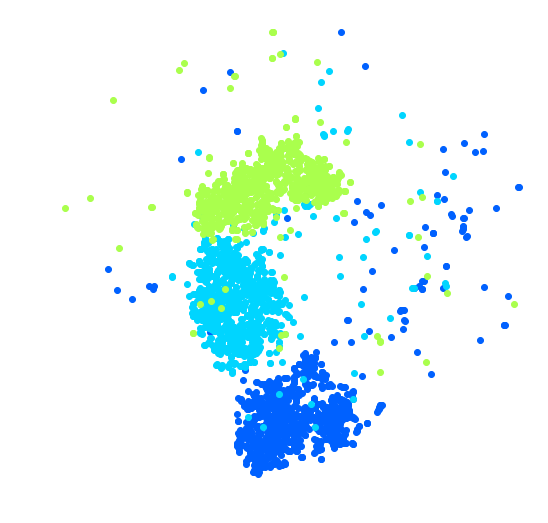

In [40]:
plt.figure(figsize = (9, 9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2,3,5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c = [cmap(digit/9)])
plt.axis("off")
plt.show()

In [36]:
idx = (y==2)|(y==3)|(y==5)

In [38]:
X_subset = X[idx]
y_subset = y[idx]

In [41]:
tsne_subset = TSNE(n_components = 2, random_state = 42)
X_subset_reduced = tsne.fit_transform(X_subset)

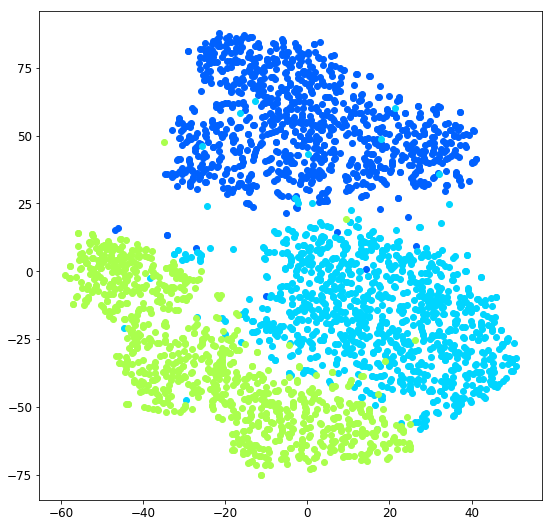

In [42]:
plt.figure(figsize = (9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2,3,5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c = [cmap(digit/9)])

In [43]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

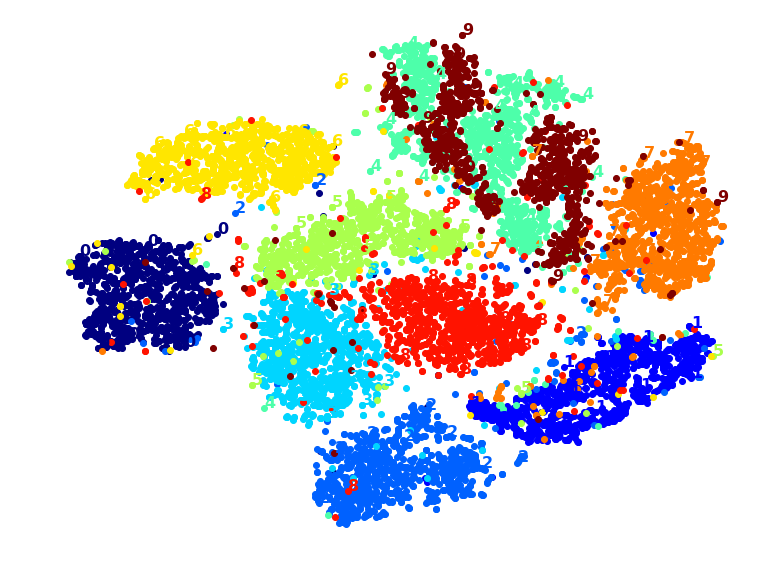

In [45]:
plot_digits(X_reduced, y)

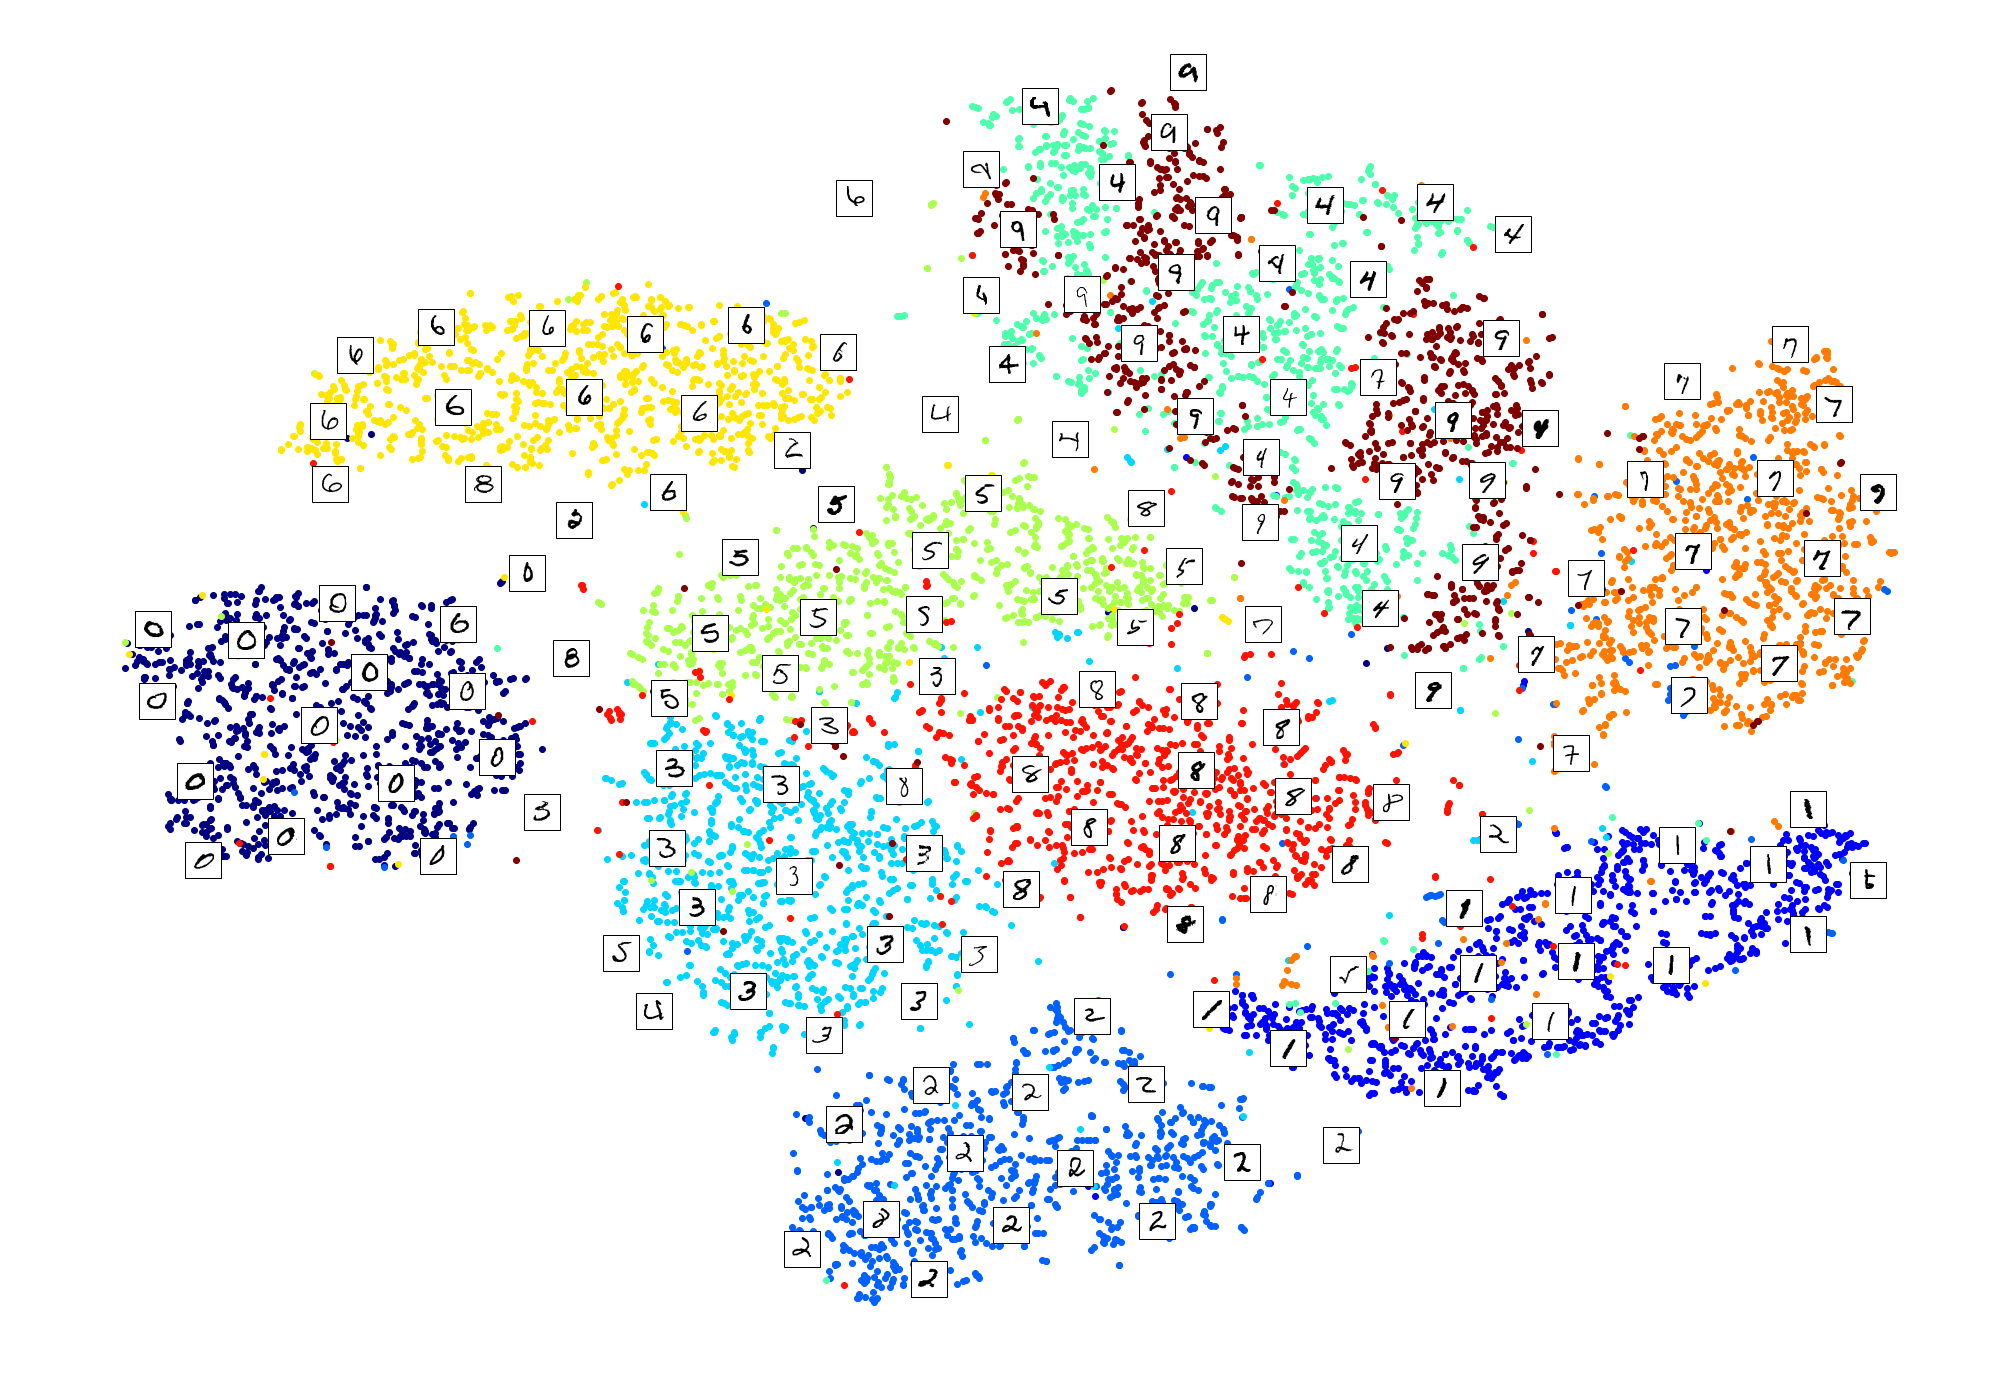

In [47]:
plot_digits(X_reduced, y, images = X, figsize = (35, 25))

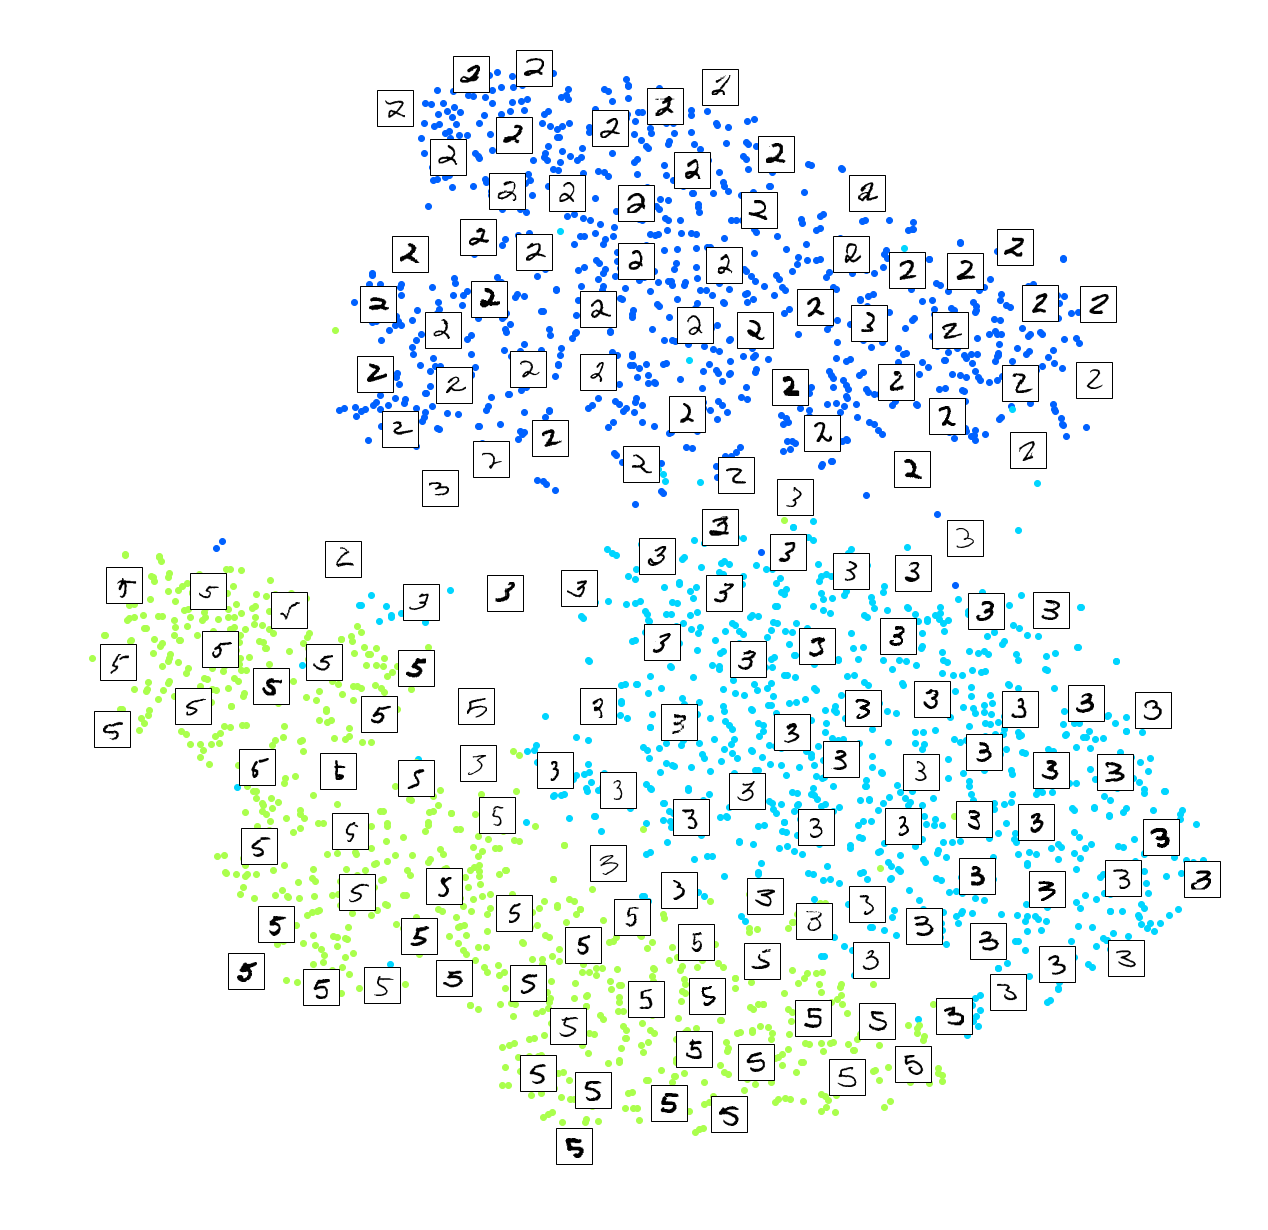

In [49]:
plot_digits(X_subset_reduced, y_subset, images = X_subset, figsize = (22, 22))

--- 0.41184306144714355 seconds ---


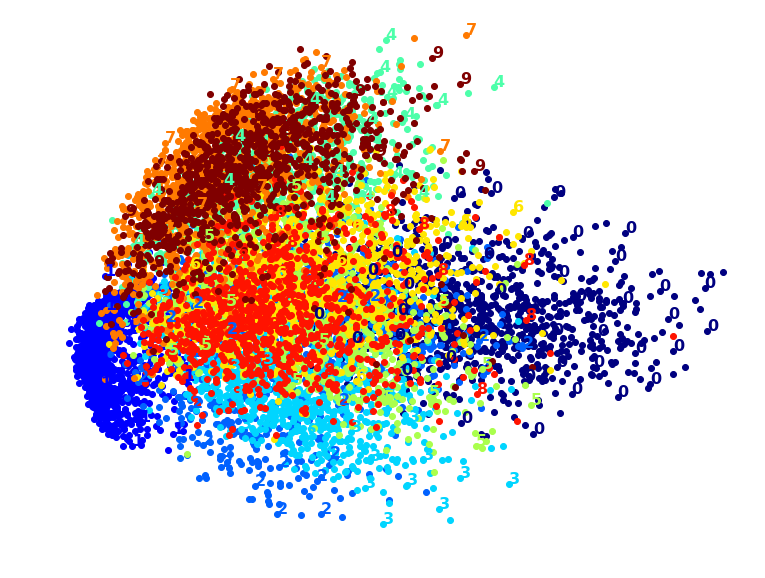

In [56]:
from sklearn.decomposition import PCA
import time

start_time = time.time()
pca = PCA(n_components = 2, random_state = 42)
X_reduced_pca = pca.fit_transform(X)
print("--- %s seconds ---" % (time.time() - start_time))

plot_digits(X_reduced_pca, y)

--- 136.61892580986023 seconds ---


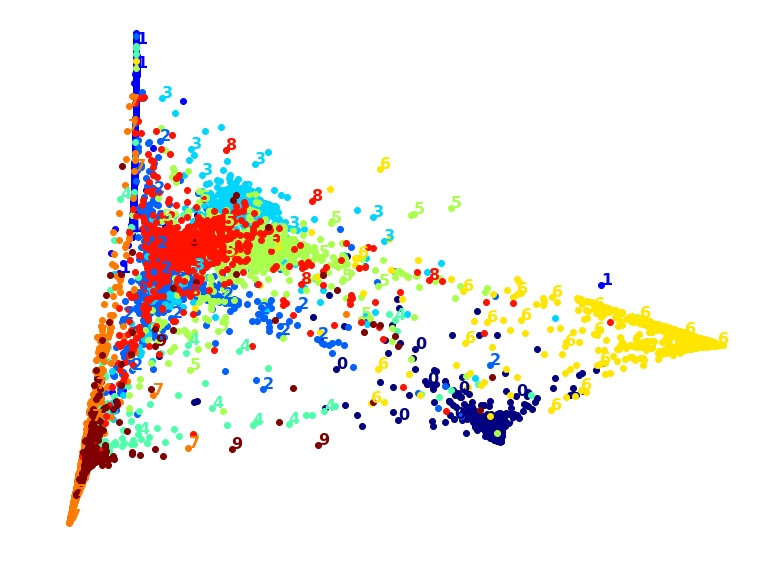

In [57]:
from sklearn.manifold import LocallyLinearEmbedding

start_time = time.time()
lle = LocallyLinearEmbedding(n_components = 2, random_state = 42)
X_reduced_lle = lle.fit_transform(X)
print("--- %s seconds ---" % (time.time() - start_time))

plot_digits(X_reduced_lle, y)

PCA+LLE took 45.4s.


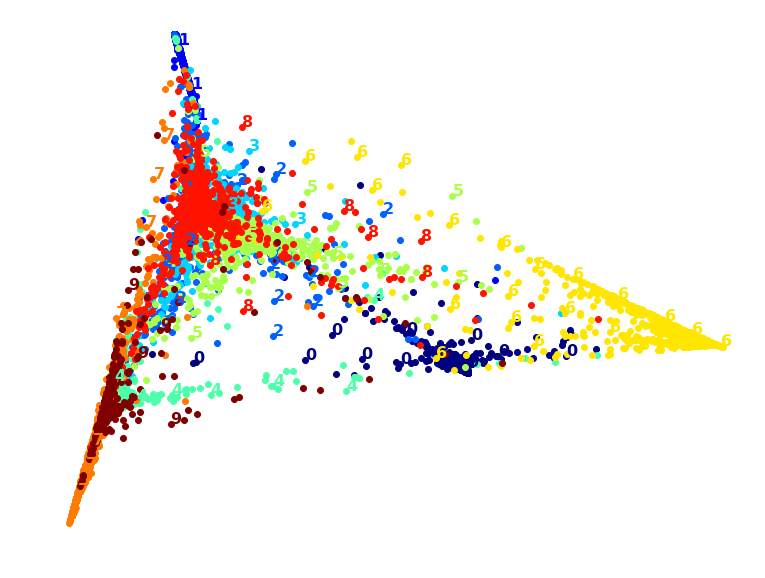

In [58]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()